# Portfolio Management
- In this section we will use the strategy we created to manage a portfolio of stocks. We will first build a trading model that include constraints such as maximum number of stocks, short-selling constraints, and transaaction costs.
- We will regress our strategies against each other to find the best combination. 
- We will get weights from the returns predictions and run our final model. 
- We will compare our results against two benchmarks: the market and a markowitz portfolio. 
- We will discuss in the appendix possible improvements. 

In [194]:
import pandas as pd
import numpy as np
import cvxpy as cp
import random 
import matplotlib.pyplot as plt

In [195]:
import numpy as np
import cvxpy as cp
def first_weights_given_returns(
    returns: np.ndarray,
    prev_weights: np.ndarray,
    tc: float = 0.001
) -> tuple[np.ndarray, float]:
    """
    Compute the weight vector w that maximizes:
        returns^T w  -  tc * ||w - prev_weights||_1
    subject to sum(w) == 1 and w >= 0.

    Parameters
    ----------
    returns : np.ndarray, shape (n,)
        Forecasted returns for each asset.
    prev_weights : np.ndarray, shape (n,)
        Previous weight allocation (must sum to 1, nonnegative).
    tc : float, default=0.001
        Transaction‐cost coefficient (multiplies the L1 distance).

    Returns
    -------
    new_weights : np.ndarray, shape (n,)
        The optimized weights (sum to 1, all ≥ 0).
    total_cost : float
        The realized transaction cost: tc * ||new_weights - prev_weights||_1
    """
    # Ensure inputs are 1-D arrays of equal length
    if returns.ndim != 1 or prev_weights.ndim != 1:
        raise ValueError("`returns` and `prev_weights` must be one‐dimensional arrays.")
    if returns.shape[0] != prev_weights.shape[0]:
        raise ValueError("`returns` and `prev_weights` must have the same length.")
    
    n = returns.shape[0]
    
    # CVXPY variable for new weights
    weights = cp.Variable(n)
    
    # L1 transaction‐cost term: ||weights - prev_weights||_1
    l1_diff = cp.norm1(weights - prev_weights)
    total_cost_expr = tc * l1_diff
    
    # Objective: maximize returns^T * weights - total_cost_expr
    objective = cp.Maximize(returns @ weights - total_cost_expr)
    
    # Constraints: sum(weights) == 1, weights >= 0
    constraints = [
        cp.sum(weights) == 1,
        weights >= -0.5
    ]
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    
    # Extract the numeric solution
    w_opt = weights.value.flatten()
    # Clip any tiny negatives, then re‐normalize to ensure sum-to-1 exactly
    w_opt = np.maximum(w_opt, 0.0)
    w_opt /= w_opt.sum()
    
    # Compute the actual transaction cost as a float
    total_cost = tc * np.linalg.norm(w_opt - prev_weights, ord=1)
    
    return w_opt, total_cost


In [196]:
def model_evaluation(weights:np.ndarray, real_returns:np.ndarray, total_cost:float):
    return sum(weights*real_returns) - total_cost

### We run some simulations 

In [197]:
def simulation(iterations: int = 10):
    """
    Run the simulation for a specified number of iterations.
    
    Parameters
    ----------
    iterations : int, default=10
        Number of iterations to run the simulation.
    """
    total_returns=0
    returns_time_zero = np.random.normal(0.001, 0.01, size=3852)
    previous_weights = returns_time_zero / returns_time_zero.sum()
    total_returns_vector= []
    real_returns_vector= []
    for i in range(iterations):
        returns_time_1 = np.random.normal(0.001, 0.01, size=3852)
        flag = np.random.binomial(n=1, p=0.55)
        if flag==1:
            noise = np.random.normal(0.00, 0.01, size=3852)
        else:
            noise = np.random.normal(-0.002, 0.01, size=3852) 
        real_returns = returns_time_1 + noise
        weights, total_cost = first_weights_given_returns(returns_time_1, prev_weights=previous_weights, tc=0.001)
        previous_weights = weights
        profit=model_evaluation(weights, real_returns, total_cost)
        total_returns += profit
        total_returns_vector.append(profit)
        real_returns_vector.append(real_returns.mean())
    print(f"Total returns over {iterations} iterations: {total_returns:.4f}")
    return total_returns,total_returns_vector, real_returns_vector


Total returns over 15 iterations: 0.5656


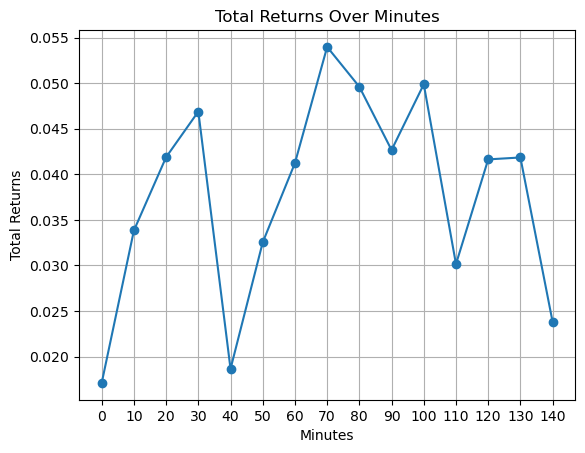

In [198]:
_,total_returns_vector,real_returns_vector=simulation(15)
plt.plot(total_returns_vector, marker='o')
#I need for the x-axis to be minutes, every iteration is 10 minutes
plt.xticks(ticks=range(len(total_returns_vector)), labels=[f"{i*10}" for i in range(len(total_returns_vector))])
plt.title('Total Returns Over Minutes')
plt.xlabel('Minutes')
plt.ylabel('Total Returns')
plt.grid()
plt.show()

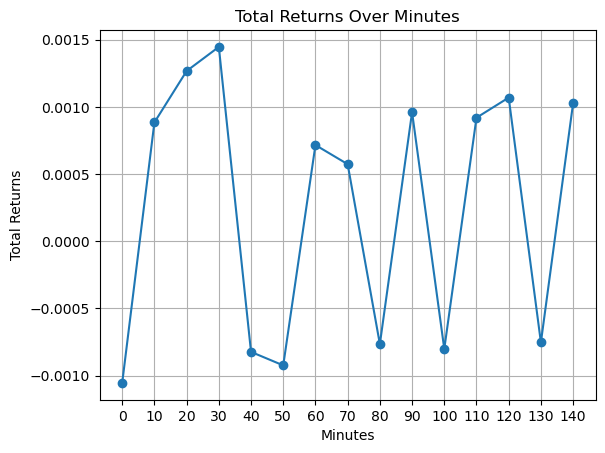

In [199]:
plt.plot(real_returns_vector, marker='o')
plt.xticks(ticks=range(len(real_returns_vector)), labels=[f"{i*10}" for i in range(len(real_returns_vector))])
plt.title('Total Returns Over Minutes')
plt.xlabel('Minutes')
plt.ylabel('Total Returns')
plt.grid()
plt.show()

### Let's now build a second strategy based on our predictions.


In [200]:
df=pd.read_parquet('data/high_10m.parquet')
df.fillna(0, inplace=True)
df['DATE']= pd.to_datetime(df['DATE'])
df.head()


,DATE,SYMBOL,TIME,ALL_EX,MID_OPEN,SUM_DELTA,RETURN
0,2021-12-01,A,09:30:00,DNYBTJVPCZUKXHA,152.190,-8.401819,0.000000
1,2021-12-01,A,09:40:00,PBTJVDZUYKNHCXM,150.490,0.473357,-0.011170
2,2021-12-01,A,09:50:00,KDPBTJVNZUCXYH,151.475,-10.867709,0.006545
3,2021-12-01,A,10:00:00,DABTJNKYVPZUXCH,150.510,-0.125414,-0.006371
4,2021-12-01,A,10:10:00,DVJTPNKUZYACBXHM,151.960,-1.274648,0.009634


In [ ]:
def markowitz_weights_given_returns(
    returns: np.ndarray,
    prev_weights: np.ndarray,
    date: str,
    tc: float = 0.001,
    df: pd.DataFrame = None
    )-> tuple[np.ndarray, float]:
    """
    Compute the weight vector w that maximizes:
        returns^Tw-tc * ||w - prev_weights||_1-1/2 * w^T Sigma w
    subject to sum(w) == 1 and w >= -0.5
    Parameters
    ----------
    returns : np.ndarray, shape (n,)
        Forecasted returns for each asset.
    prev_weights : np.ndarray, shape (n,)
        Previous weight allocation (must sum to 1, nonnegative).
    tc : float, default=0.001
        Transaction‐cost coefficient (multiplies the L1 distance).
    df : pd.DataFrame, to calculate the covariance matrix Sigma
    date : str, the date for which we want to calculate the covariance matrix
    Returns
    -------
    new_weights : np.ndarray, shape (n,)
        The optimized weights (sum to 1, all ≥ -0.5).
    total_cost : float
        The realized transaction cost: tc * ||new_weights - prev_weights||_1
    """
    # Ensure inputs are 1-D arrays of equal length
    if returns.ndim != 1 or prev_weights.ndim != 1:
        raise ValueError("`returns` and `prev_weights` must be one‐dimensional arrays.")
    if returns.shape[0] != prev_weights.shape[0]:
        raise ValueError("`returns` and `prev_weights` must have the same length.")
    
    n = returns.shape[0]
    df_before = df.loc[df['DATE'] < date]

    # Pivot so that each SYMBOL becomes its own column
    #    and each row is a (DATE, TIME) pair:
    df_wide = df_before.pivot(
            index=["DATE", "TIME"],
            columns="SYMBOL",
            values="RETURN"
    )
    df_wide = df_wide.fillna(0.0)
    sigma_df = df_wide.cov()
    # CVXPY variable for new weights
    weights = cp.Variable(n)

    sigma_hat = sigma_df.values
    sigma_hat = 0.5 * (sigma_hat + sigma_hat.T) #PORCODIO CVXPY STAI ZITTO DIOCANE SE NON E' SIMMETRICA ALLA DIOCANE DI QUINTA CIFRA DECIMALE
    variance_term = cp.quad_form(weights, sigma_hat)
    # L1 transaction‐cost term: ||weights - prev_weights||_1
    l1_diff = cp.norm1(weights - prev_weights)
    # Total cost expression
    total_cost_expr = tc * l1_diff
    
    # Objective: maximize returns^T * weights - total_cost_expr
    objective = cp.Maximize(returns @ weights - total_cost_expr- 0.5 * variance_term)
    
    # Constraints: sum(weights) == 1, weights >= 0
    constraints = [
        cp.sum(weights) == 1,
        weights >= -0.5
    ]
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    
    # Extract the numeric solution
    w_opt = weights.value.flatten()
    # Clip any tiny negatives, then re‐normalize to ensure sum-to-1 exactly
    w_opt = np.maximum(w_opt, 0.0)
    w_opt /= w_opt.sum()
    
    # Compute the actual transaction cost as a float
    total_cost = tc * np.linalg.norm(w_opt - prev_weights, ord=1)
    
    return w_opt, total_cost


### Let's run some simulations

In [218]:
num_symbols = df["SYMBOL"].nunique()
print(f"Number of unique symbols: {num_symbols}")

Number of unique symbols: 9509


In [219]:
def simulation_markowitz(iterations: int = 10):
    """
    Run the simulation for a specified number of iterations.
    
    Parameters
    ----------
    iterations : int, default=10
        Number of iterations to run the simulation.
    """
    total_returns=0
    returns_time_zero = np.random.normal(0.001, 0.01, size=9372)
    previous_weights = returns_time_zero / returns_time_zero.sum()
    total_returns_vector= []
    real_returns_vector= []
    for i in range(iterations):
        returns_time_1 = np.random.normal(0.001, 0.01, size=9372)
        flag = np.random.binomial(n=1, p=0.55)
        if flag==1:
            noise = np.random.normal(0.00, 0.01, size=9372)
        else:
            noise = np.random.normal(-0.002, 0.01, size=9372) 
        real_returns = returns_time_1 + noise
        weights, total_cost = markowitz_weights_given_returns(returns_time_1, prev_weights=previous_weights, tc=0.001, date='2021-12-10', df=df)
        previous_weights = weights
        profit=model_evaluation(weights, real_returns, total_cost)
        total_returns += profit
        total_returns_vector.append(profit)
        real_returns_vector.append(real_returns.mean())
    print(f"Total returns over {iterations} iterations: {total_returns:.4f}")
    return total_returns,total_returns_vector, real_returns_vector


(9372, 9372)
Total returns over 1 iterations: 0.0314


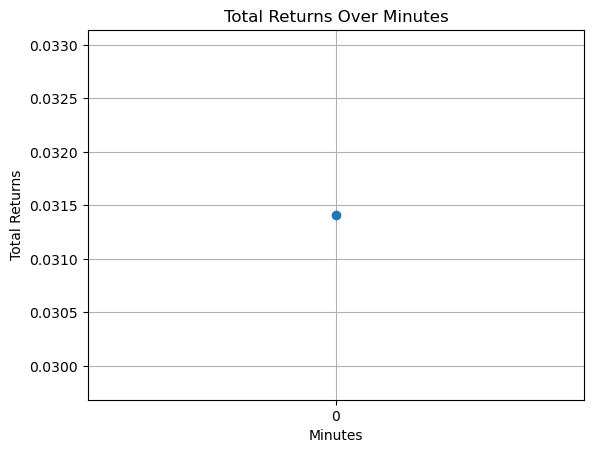

In [222]:
_,total_returns_vector,real_returns_vector=simulation_markowitz(1)
plt.plot(total_returns_vector, marker='o')
#I need for the x-axis to be minutes, every iteration is 10 minutes
plt.xticks(ticks=range(len(total_returns_vector)), labels=[f"{i*10}" for i in range(len(total_returns_vector))])
plt.title('Total Returns Over Minutes')
plt.xlabel('Minutes')
plt.ylabel('Total Returns')
plt.grid()
plt.show()

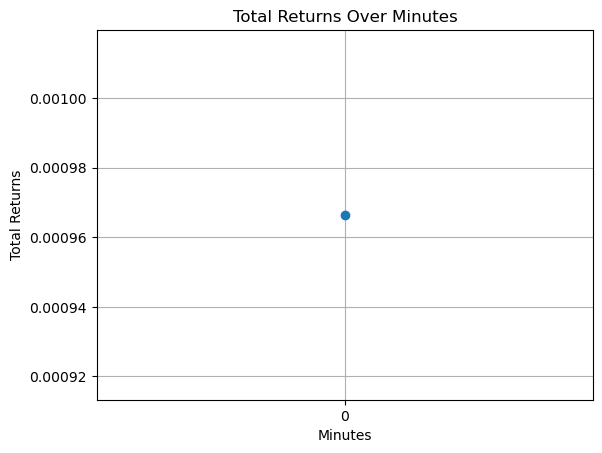

In [223]:
plt.plot(real_returns_vector, marker='o')
plt.xticks(ticks=range(len(real_returns_vector)), labels=[f"{i*10}" for i in range(len(real_returns_vector))])
plt.title('Total Returns Over Minutes')
plt.xlabel('Minutes')
plt.ylabel('Total Returns')
plt.grid()
plt.show()